### Aspect Based Sentiment Analysis

##### I- Data Extraction

In [1]:
from bs4 import BeautifulSoup
import lxml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def extract_metadata(path):
    
    with open(path, "r",encoding="utf-8") as f:
        file = f.read()
    
    bs_content = BeautifulSoup(file,"xml")
    
    ids, texts, themes, polarities = [], [], [], []
    theme_starts, theme_ends = [], []
    for id in bs_content.find_all("Review"):
        review_id = id.get("rid")
        for sentence in id.find_all("sentence"):
            text = sentence.find("text").text
            for opinion in sentence.find_all("Opinion"):
                polarity = opinion.get("polarity")
                theme = opinion.get("target")
                theme_start = int(opinion.get("from"))
                theme_end = int(opinion.get("to"))
                if theme == "NULL":
                    continue

                ids.append(review_id)
                texts.append(text.lower())
                themes.append(theme.lower())
                polarities.append(polarity)
                theme_starts.append(theme_start)
                theme_ends.append(theme_end)
    
    assert len(ids) == len(texts), "ERROR: ids length is different from texts length"
    assert len(ids) == len(themes), "ERROR: ids length is different from themes length"
    assert len(ids) == len(polarities), "ERROR: ids length is different from polarities length"
    assert len(ids) == len(theme_starts),"ERROR: ids length is different from theme starts length"
    assert len(ids) == len(theme_ends),"ERROR: ids length is different from theme ends length"
    
    return ids, texts, themes, polarities, theme_starts, theme_ends           

In [3]:
path_train = r'train\ABSA16FR_Restaurants_Train-withcontent.xml'
path_test = r'test_restaurant\ABSA16FR_Restaurants_Gold-withcontent.xml'

In [4]:
ids_train, texts_train, themes_train, polarities_train,theme_starts_train, theme_ends_train = extract_metadata(path_train)
dataset_train = {
    "id":ids_train,
    "text": texts_train,
    "theme": themes_train,
    "polarity":polarities_train,
    "theme_starts": theme_starts_train,
    "theme_ends": theme_ends_train
}
# Create dataframe
df_train = pd.DataFrame(dataset_train)

In [5]:
ids_test, texts_test, themes_test, polarities_test,theme_starts_test, theme_ends_test = extract_metadata(path_test)
dataset_test = {
    "id":ids_test,
    "text": texts_test,
    "theme": themes_test,
    "polarity":polarities_test,
    "theme_starts": theme_starts_test,
    "theme_ends": theme_ends_test
}
# Create dataframe
df_test = pd.DataFrame(dataset_test)

In [6]:
def label_to_id_transform(label):
    
    if label == "neutral":
        return 0
    elif label == "negative":
        return 1
    elif label == "positive":
        return 2

In [7]:
df_train["polarity_id"] = df_train["polarity"].apply(label_to_id_transform)
df_test["polarity_id"] = df_test["polarity"].apply(label_to_id_transform)

In [8]:
# Save dataframe
df_train.to_csv("dataset/train.csv", index=False)
df_test.to_csv("dataset/test.csv", index=False)

#### II- Exploratory Data Analysis

In [2]:
df = pd.read_csv("dataset/train.csv")

In [3]:
df.head()

,id,text,theme,polarity,theme_starts,theme_ends,polarity_id
0,g1079435-d3498474-r271346275,"Un service passable .. Des plats surcuits, des...",service,neutral,3,10,0
1,g1079435-d3498474-r271346275,"Un service passable .. Des plats surcuits, des...",plats,negative,27,32,1
2,g1079435-d3498474-r271346275,"Un service passable .. Des plats surcuits, des...",sauces,negative,47,53,1
3,g1079435-d3498474-r271346275,"Un service passable .. Des plats surcuits, des...",resto,negative,242,247,1
4,g1080298-d1332050-r275655485,"Nous avons bien aimé l'ambiance, sur la promen...",ambiance,positive,23,31,2


In [11]:
df.shape

(1770, 7)

In [12]:
df.columns

Index(['id', 'text', 'theme', 'polarity', 'theme_starts', 'theme_ends',
       'polarity_id'],
      dtype='object')

In [13]:
df.isna().sum()

id              0
text            0
theme           0
polarity        0
theme_starts    0
theme_ends      0
polarity_id     0
dtype: int64

In [14]:
df.groupby("polarity").count()

,id,text,theme,theme_starts,theme_ends,polarity_id
polarity,,,,,,
negative,753,753,753,753,753,753
neutral,116,116,116,116,116,116
positive,901,901,901,901,901,901


Text(0.5, 1.0, "Nombre d'exemple par classe")

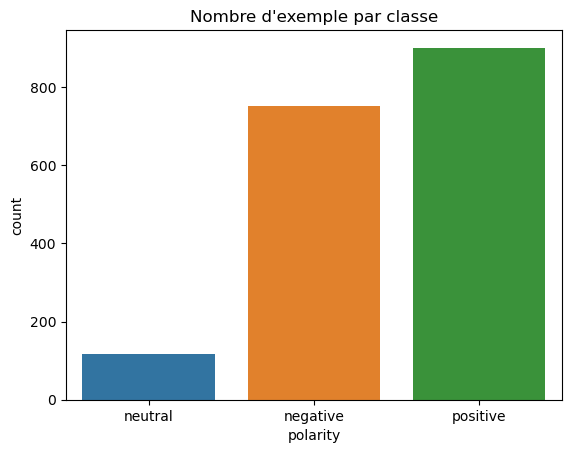

In [15]:
sns.countplot(x=df["polarity"])
plt.title("Nombre d'exemple par classe")

In [16]:
df["text_length"] = df["text"].apply(
    lambda x: len(x.split())
)

Text(0.5, 1.0, 'Distribution taille des textes')

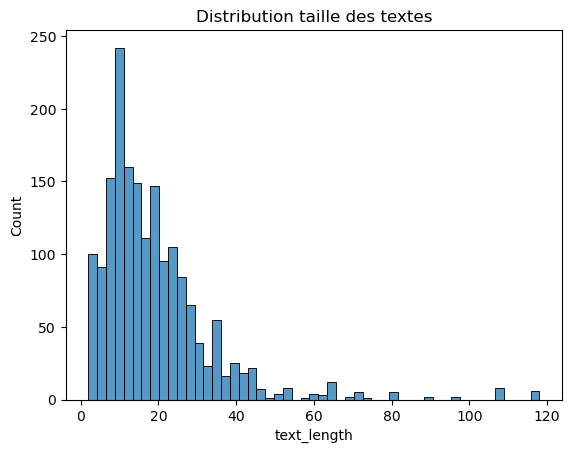

In [17]:
sns.histplot(df["text_length"])
plt.title("Distribution taille des textes")

### III- Model training

### 1- Training without marking theme position in the sentence

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("csv", data_files="dataset/train.csv")
test_dataset = load_dataset("csv", data_files="dataset/test.csv")

Found cached dataset csv (C:/Users/hella/.cache/huggingface/datasets/csv/default-23400b862703960f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset csv (C:/Users/hella/.cache/huggingface/datasets/csv/default-886437a754511ad6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'theme', 'polarity', 'theme_starts', 'theme_ends', 'polarity_id'],
        num_rows: 718
    })
})

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [5]:
BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 4
EPOCHS = 10

In [6]:
id2label = {"neutral":0, "negative": 1, "positive": 2}
label2id = {v:k for k,v in id2label.items()}

In [7]:
# Fixing the seed
from transformers import set_seed
set_seed(42)

In [8]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

In [9]:
dataset = {"train": train_dataset["train"], "test": test_dataset["train"]}

def get_features(examples):
    
    labels = examples["polarity_id"]
    examples["text"] = examples["text"] + " " + tokenizer.sep_token + " " + examples["theme"]
    examples = tokenizer(
        examples["text"],
        max_length = MAX_LENGTH,
        truncation = True,
        padding = "max_length"
    )
    
    examples["label"] = labels
    
    return examples

In [10]:
for data_type in dataset:
    dataset[data_type] = dataset[data_type].map(
        get_features, remove_columns=["id","text","theme","polarity","polarity_id","theme_starts","theme_ends"]
    )

Loading cached processed dataset at C:\Users\hella\.cache\huggingface\datasets\csv\default-23400b862703960f\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-a816fd0157f68cf2.arrow


Map:   0%|          | 0/718 [00:00<?, ? examples/s]

In [11]:
import evaluate
f1_metric = evaluate.load("f1")

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [13]:
import torch

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
model.to(device)

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0): CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "model/without_marking",
    learning_rate = LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset = dataset["train"],
    eval_dataset= dataset["test"],
    compute_metrics=compute_metrics
)



In [18]:
trainer.train()

C:\Users\hella\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1770
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4430
  Number of trainable parameters = 110624259


Epoch,Training Loss,Validation Loss,F1
1,No log,0.651396,0.552482
2,0.622000,0.522716,0.627692
3,0.389800,0.690186,0.652682
4,0.268800,0.685600,0.733477
5,0.205300,0.662686,0.776930
6,0.164400,0.647773,0.779555
7,0.130800,0.646415,0.785623
8,0.092200,0.716057,0.786759
9,0.092200,0.728910,0.775806
10,0.094000,0.729548,0.786710


***** Running Evaluation *****
  Num examples = 718
  Batch size = 4
Saving model checkpoint to model/without_marking\checkpoint-443
Configuration saved in model/without_marking\checkpoint-443\config.json
Model weights saved in model/without_marking\checkpoint-443\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 718
  Batch size = 4
Saving model checkpoint to model/without_marking\checkpoint-886
Configuration saved in model/without_marking\checkpoint-886\config.json
Model weights saved in model/without_marking\checkpoint-886\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 718
  Batch size = 4
Saving model checkpoint to model/without_marking\checkpoint-1329
Configuration saved in model/without_marking\checkpoint-1329\config.json
Model weights saved in model/without_marking\checkpoint-1329\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 718
  Batch size = 4
Saving model checkpoint to model/without_marking\checkpoint-1772
Configuration 

TrainOutput(global_step=4430, training_loss=0.22980517178572057, metrics={'train_runtime': 1094.1331, 'train_samples_per_second': 16.177, 'train_steps_per_second': 4.049, 'total_flos': 2328553746892800.0, 'train_loss': 0.22980517178572057, 'epoch': 10.0})

In [19]:
trainer.eval_dataset=dataset["test"]
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 718
  Batch size = 4


{'eval_loss': 0.716057300567627,
 'eval_f1': 0.7867592066730705,
 'eval_runtime': 11.1161,
 'eval_samples_per_second': 64.591,
 'eval_steps_per_second': 16.193,
 'epoch': 10.0}

In [20]:
model.save_pretrained("model/without_marking//best_checkpoint")

Configuration saved in model/without_marking//best_checkpoint\config.json
Model weights saved in model/without_marking//best_checkpoint\pytorch_model.bin


In [21]:
tokenizer.save_pretrained("model/without_marking/best_checkpoint")

tokenizer config file saved in model/without_marking/best_checkpoint\tokenizer_config.json
Special tokens file saved in model/without_marking/best_checkpoint\special_tokens_map.json


('model/without_marking/best_checkpoint\\tokenizer_config.json',
 'model/without_marking/best_checkpoint\\special_tokens_map.json',
 'model/without_marking/best_checkpoint\\sentencepiece.bpe.model',
 'model/without_marking/best_checkpoint\\added_tokens.json',
 'model/without_marking/best_checkpoint\\tokenizer.json')

In [22]:
def transform_text(examples):
    examples["text"] = examples["text"] + " " + tokenizer.sep_token + " " + examples["theme"]
    
    return examples

In [23]:
test_dataset = test_dataset.map(transform_text)

Loading cached processed dataset at C:\Users\hella\.cache\huggingface\datasets\csv\default-886437a754511ad6\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8507610b4bf18038.arrow


In [24]:
import math
import pandas as pd

nb_batches = math.ceil(len(test_dataset["train"])/BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = test_dataset["train"][i * BATCH_SIZE: (i+1) * BATCH_SIZE]["text"]
    input_labels = test_dataset["train"][i * BATCH_SIZE: (i+1) * BATCH_SIZE]["polarity_id"]
    encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=256, return_tensors="pt").to(device)
    y_preds += np.argmax(model(**encoded).logits.detach().cpu(),axis=-1).tolist()

In [25]:
df = pd.DataFrame(
    [test_dataset["train"]["text"],test_dataset["train"]["theme"], test_dataset["train"]["polarity_id"], y_preds],
    ["text", "theme","polarity","predicted_polarity"]
).T

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(
    df["polarity"].tolist(),
    df["predicted_polarity"].tolist(),
    target_names=["neutral","positive", "negative"],
    digits=3
))

              precision    recall  f1-score   support

     neutral       0.67      0.46      0.55        69
    positive       0.89      0.93      0.91       285
    negative       0.90      0.92      0.91       364

    accuracy                           0.88       718
   macro avg       0.82      0.77      0.79       718
weighted avg       0.87      0.88      0.87       718



In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df["polarity"].tolist(), df["predicted_polarity"].tolist())

array([[ 32,  14,  23],
       [  6, 264,  15],
       [ 10,  20, 334]], dtype=int64)

In [66]:
index = 8
#print(df[(df["polarity"] == 0) & (df["predicted_polarity"] != 0)].iloc[index]["text"])
#print(df[(df["polarity"] == 0) & (df["predicted_polarity"] != 0)].iloc[index]["predicted_polarity"])

df[(df["polarity"] == 1) & (df["predicted_polarity"] != 1)]

,text,theme,polarity,predicted_polarity
2,Le prix est un peu élevé pour un repas qui n'a...,repas,1,0
94,surprise avant même de passer la commande : un...,serveuse,1,2
112,assiette de fromage au singulier ..... </s> as...,assiette de fromage,1,2
167,"3 plats arrivent enfin, puis une viande demand...",viande,1,2
180,"Ravioles et tartiflette correctes, crêpe suzet...",crêpe suzette,1,0
250,le service etait proche du zero absolue et le ...,bouffe,1,0
253,je pense me rattraper sur le dessert avec la m...,mousse au chocolat,1,2
308,"Le repas était assez bon, mais tout est sûreme...",repas,1,2
309,Nous avons découvert ce restaurant avec Groupo...,restaurant,1,2
344,"Il y a quelques années, le burger en forme de ...",burger,1,2


In [67]:
df.to_csv("dataset/prediction.csv",index=False)

### 1- Training with marking theme position in the sentence

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("csv", data_files="dataset/train.csv")
test_dataset = load_dataset("csv", data_files="dataset/test.csv")

Found cached dataset csv (C:/Users/hella/.cache/huggingface/datasets/csv/default-23400b862703960f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset csv (C:/Users/hella/.cache/huggingface/datasets/csv/default-886437a754511ad6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [4]:
BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 4
EPOCHS = 10

In [5]:
id2label = {"neutral":0, "negative": 1, "positive": 2}
label2id = {v:k for k,v in id2label.items()}

In [6]:
# Fixing the seed
from transformers import set_seed
set_seed(42)

In [8]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [11]:
dataset = {"train": train_dataset["train"], "test": test_dataset["train"]}

def get_features(examples):
    
    labels = examples["polarity_id"]
    
    # Extracting elements for verbatim construction
    text = examples["text"]
    theme = examples["theme"]
    start = examples["theme_starts"]
    end = examples["theme_ends"]
    
    examples["text"] = text[:start] + '"' + text[start:end] + '" ' + text[end+1:] + tokenizer.sep_token + " " + theme
    
    examples = tokenizer(
        examples["text"],
        max_length = MAX_LENGTH,
        truncation = True,
        padding = "max_length"
    )
    
    examples["label"] = labels
    
    return examples

In [12]:
for data_type in dataset:
    dataset[data_type] = dataset[data_type].map(
        get_features, remove_columns=["id","text","theme","polarity","polarity_id","theme_starts","theme_ends"]
    )

Map:   0%|          | 0/1770 [00:00<?, ? examples/s]

Map:   0%|          | 0/718 [00:00<?, ? examples/s]

In [13]:
import evaluate
f1_metric = evaluate.load("f1")

In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [15]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0): CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "model/with_marking",
    learning_rate = LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset = dataset["train"],
    eval_dataset= dataset["test"],
    compute_metrics=compute_metrics
)

In [18]:
trainer.train()

C:\Users\hella\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1770
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4430
  Number of trainable parameters = 110624259


Epoch,Training Loss,Validation Loss,F1
1,No log,0.569096,0.589903
2,0.584300,0.429096,0.748856
3,0.369200,0.631268,0.733282
4,0.257500,0.673415,0.749640
5,0.184700,0.681142,0.773675
6,0.140300,0.697807,0.783118
7,0.131300,0.672519,0.793332
8,0.098600,0.712560,0.771089
9,0.098600,0.715070,0.784351
10,0.076700,0.716301,0.794138


***** Running Evaluation *****
  Num examples = 718
  Batch size = 4
Saving model checkpoint to model/with_marking\checkpoint-443
Configuration saved in model/with_marking\checkpoint-443\config.json
Model weights saved in model/with_marking\checkpoint-443\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 718
  Batch size = 4
Saving model checkpoint to model/with_marking\checkpoint-886
Configuration saved in model/with_marking\checkpoint-886\config.json
Model weights saved in model/with_marking\checkpoint-886\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 718
  Batch size = 4
Saving model checkpoint to model/with_marking\checkpoint-1329
Configuration saved in model/with_marking\checkpoint-1329\config.json
Model weights saved in model/with_marking\checkpoint-1329\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 718
  Batch size = 4
Saving model checkpoint to model/with_marking\checkpoint-1772
Configuration saved in model/with_marking\ch

TrainOutput(global_step=4430, training_loss=0.21415282522851672, metrics={'train_runtime': 1090.8504, 'train_samples_per_second': 16.226, 'train_steps_per_second': 4.061, 'total_flos': 2328553746892800.0, 'train_loss': 0.21415282522851672, 'epoch': 10.0})

In [19]:
trainer.eval_dataset=dataset["test"]
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 718
  Batch size = 4


{'eval_loss': 0.7163009643554688,
 'eval_f1': 0.7941382302274914,
 'eval_runtime': 11.0249,
 'eval_samples_per_second': 65.126,
 'eval_steps_per_second': 16.327,
 'epoch': 10.0}

In [20]:
model.save_pretrained("model/with_marking/best_checkpoint")

Configuration saved in model/with_marking/best_checkpoint\config.json
Model weights saved in model/with_marking/best_checkpoint\pytorch_model.bin


In [21]:
tokenizer.save_pretrained("model/with_marking/best_checkpoint")

tokenizer config file saved in model/with_marking/best_checkpoint\tokenizer_config.json
Special tokens file saved in model/with_marking/best_checkpoint\special_tokens_map.json


('model/with_marking/best_checkpoint\\tokenizer_config.json',
 'model/with_marking/best_checkpoint\\special_tokens_map.json',
 'model/with_marking/best_checkpoint\\sentencepiece.bpe.model',
 'model/with_marking/best_checkpoint\\added_tokens.json',
 'model/with_marking/best_checkpoint\\tokenizer.json')

In [24]:
def transform_text(examples):
    # Extracting elements for verbatim construction
    text = examples["text"]
    theme = examples["theme"]
    start = examples["theme_starts"]
    end = examples["theme_ends"]
    
    examples["text"] = text[:start] + '"' + text[start:end] + '" ' + text[end+1:] + tokenizer.sep_token + " " + theme
    
    return examples

In [25]:
test_dataset = test_dataset.map(transform_text)

Map:   0%|          | 0/718 [00:00<?, ? examples/s]

In [32]:
dataset["test"]

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 718
})

In [31]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'theme', 'polarity', 'theme_starts', 'theme_ends', 'polarity_id'],
        num_rows: 718
    })
})

In [26]:
import math
import pandas as pd

nb_batches = math.ceil(len(test_dataset["train"])/BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = test_dataset["train"][i * BATCH_SIZE: (i+1) * BATCH_SIZE]["text"]
    input_labels = test_dataset["train"][i * BATCH_SIZE: (i+1) * BATCH_SIZE]["polarity_id"]
    encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=256, return_tensors="pt").to(device)
    y_preds += np.argmax(model(**encoded).logits.detach().cpu(),axis=-1).tolist()

In [27]:
df = pd.DataFrame(
    [test_dataset["train"]["text"],test_dataset["train"]["theme"], test_dataset["train"]["polarity_id"], y_preds],
    ["text", "theme","polarity","predicted_polarity"]
).T

In [28]:
from sklearn.metrics import classification_report

In [29]:
print(classification_report(
    df["polarity"].tolist(),
    df["predicted_polarity"].tolist(),
    target_names=["neutral","positive", "negative"],
    digit=3
))

              precision    recall  f1-score   support

     neutral       0.60      0.52      0.56        69
    positive       0.90      0.92      0.91       285
    negative       0.91      0.91      0.91       364

    accuracy                           0.88       718
   macro avg       0.80      0.79      0.79       718
weighted avg       0.88      0.88      0.88       718

